# VS associations with cognitive performance (P) with an interaction with DRD2 polymorphism

***

In [41]:
import matplotlib.pyplot as plt
import ptitprince as pt
import pandas as pd
import numpy as np
import random
from scipy import stats
from scipy.stats import beta
from scipy.special import betaln
#from statsmodels.compat import unicode
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from IPython.core.display import HTML
#import pymc3 as pm
import math
from sklearn.utils import resample
from resample.bootstrap import bootstrap

### Loading Datasets

In [2]:
# Loading data
data = pd.read_csv('DRD2_subset_data.csv', delimiter=',')
data = data.dropna(subset=['P','Q','VS','DRD2', 'AGE', 'female_1'])

# Loading second IGT only data (Reformatted)
IGT_data = pd.read_csv('DRD2_IGT_subset_data.csv', delimiter=',')
IGT_data = IGT_data.dropna(subset=['IGT_scores', 'DRD2'])

### Reformatting Data

In [3]:
# Changing Categorical data to integers
data['DRD2'] = data['DRD2'].astype(int)
data['female_1'] = data['female_1'].astype(int)
IGT_data['DRD2'] = IGT_data['DRD2'].astype(int)

# Changing DRD2 data to category type
data['DRD2_cat'] = pd.cut(data['DRD2'], range(-1,2,1), labels=['Non-Carrier', '-141C Ins/Del Carrier'])
data['DRD2_cat'] = data['DRD2_cat'].astype('object')
IGT_data['DRD2_cat'] = pd.cut(IGT_data['DRD2'], range(-1,2,1), labels=['Non-Carrier', '-141C Ins/Del Carrier'])
IGT_data['DRD2_cat'] = IGT_data['DRD2_cat'].astype('object')

# Splitting data based on DRD2 polymorphism
carrier = data[data['DRD2'] == 1] # Low D2 Receptors
noncarrier = data[data['DRD2'] == 0] # Normal D2 Receptors

## Distribution Plots Version 1

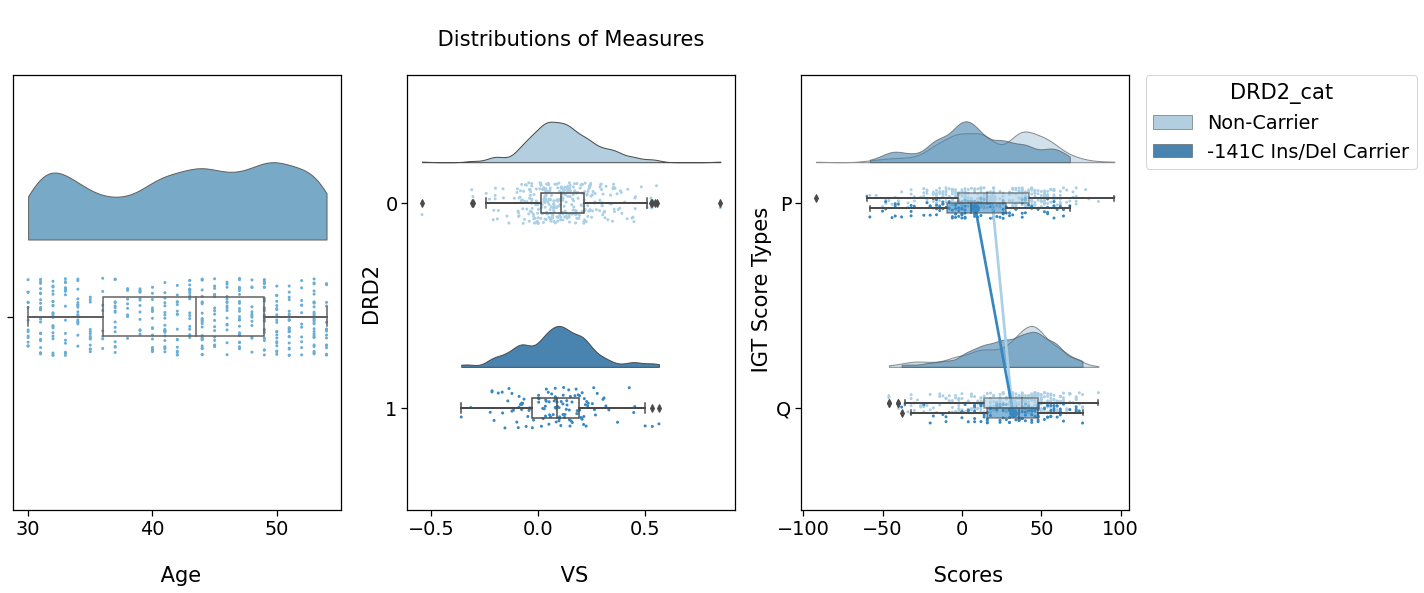

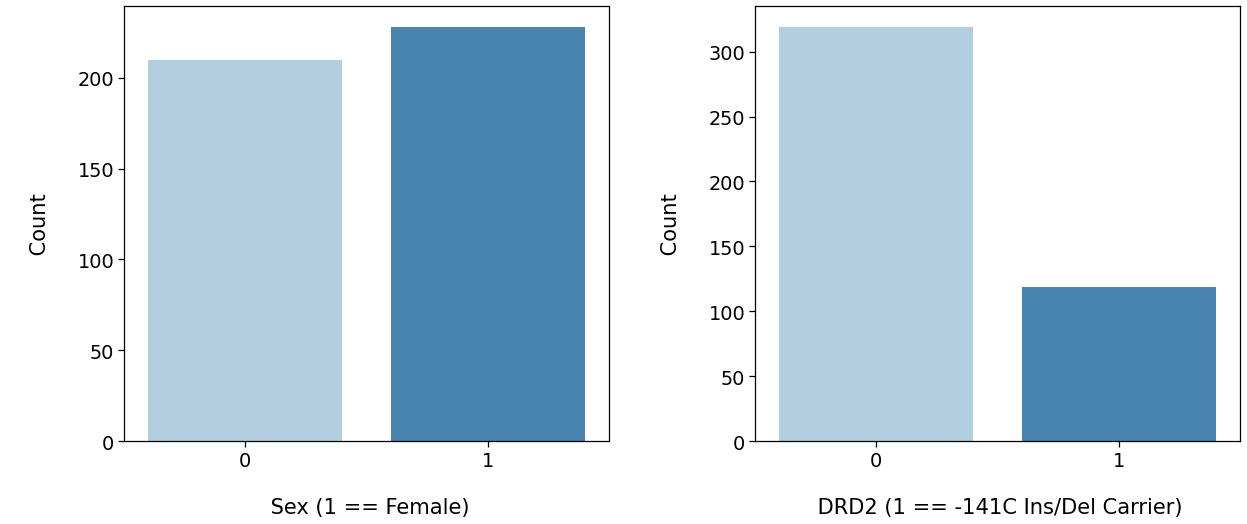

In [90]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.75)

# Configuring 1st row of grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(8)
fig.set_figwidth(20)


# Age Rain Cloud Plot
ax = fig.add_subplot(1, 3, 1)
age = pt.RainCloud(y='AGE', orient='h',data=data, width_viol=.4, width_box=.1, 
                   palette="Blues",ax=ax)
age.set(xlabel='\n Age')

# VS Rain Cloud Plot
ax = fig.add_subplot(1, 3, 2)
VS = pt.RainCloud(y='VS', x='DRD2', data=data, orient='h', width_viol=.4, width_box=.1, 
                  palette="Blues", ax=ax)
VS.set(xlabel='\n VS', title='\n Distributions of Measures \n')

# IGT Scores Rain Cloud Plots
ax = fig.add_subplot(1, 3, 3)
IGT = pt.RainCloud(y='IGT_scores', x='IGT_score_type', hue='DRD2_cat', data=IGT_data, orient='h', 
                         width_viol=.4, width_box=.1, palette='Blues', alpha=.6, ax=ax,
                          dodge=True, pointplot=True) #Can comment out if lines aren't helpful
IGT.set(xlabel='\n Scores', ylabel='\n IGT Score Types')

# Configuring 2nd row of grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.3)
fig.set_figheight(8)
fig.set_figwidth(20)

# Sex Bar Plot
ax = fig.add_subplot(1, 2, 1)
sex = sns.countplot(x="female_1", data=data, palette="Blues", ax=ax)
ax.set(xlabel='\n Sex (1 == Female)', ylabel='\n Count \n')

# DRD2 Bar Plot
ax = fig.add_subplot(1, 2, 2)
DRD2 = sns.countplot(x="DRD2", data=data, palette="Blues", ax=ax)
ax.set(xlabel='\n DRD2 (1 == -141C Ins/Del Carrier)', ylabel='\n Count \n')

plt.close(3)
plt.close(4)

plt.show()

## Distribution Plots Version 2

<Figure size 432x288 with 0 Axes>

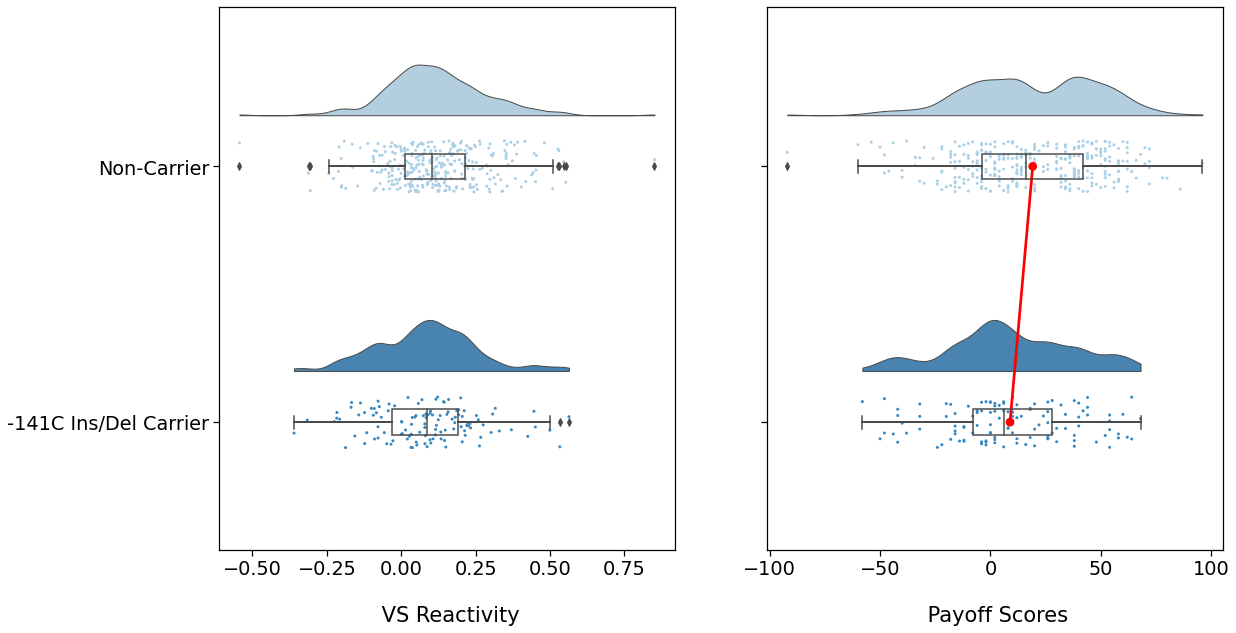

In [92]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.75)

# Configuring 1st row of grid of plots
fig = plt.figure()
fig, axs = plt.subplots(1,2, figsize=(18,10), sharey=True)
axs= axs.ravel()

# VS Rain Cloud Plot
VS = pt.RainCloud(y='VS', x='DRD2_cat', data=data, orient='h', width_viol=.4, width_box=.1, 
                  palette="Blues", ax=axs[0])
VS.set(xlabel='\n VS Reactivity', ylabel='')

# IGT Scores Rain Cloud Plots
IGT = pt.RainCloud(y='P', x='DRD2_cat', data=data, orient='h', width_viol=.4, width_box=.1, 
                   palette='Blues', pointplot=True, ax=axs[1])
IGT.set(xlabel='\n Payoff Scores', ylabel='')
#ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#plt.legend([], ["Attr A", "Attr A+B"])
plt.show()

***


# T-Tests

### T-Test between DRD2 vs P and Q

In [41]:
t_test_results = stats.ttest_ind(carrier.iloc[:,2:5], noncarrier.iloc[:,2:5], equal_var=True)
cols = ['P', 'Q', 'VS']
pd.DataFrame({'Statistics':t_test_results.statistic[0:], 'P-values':t_test_results.pvalue}, cols)


,Statistics,P-values
P,-3.230837,0.001328
Q,0.539049,0.590128
VS,-1.771730,0.077138


### Linear Regression Plots

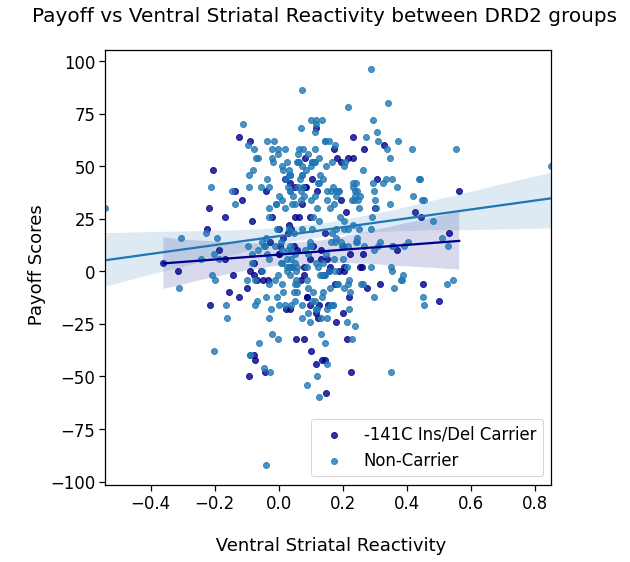

In [87]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.5)

# Configuring plot
fig = plt.figure(figsize=(8,8))

# P vs VS between DRD2 groups Scatter Plot
scatter_P_low = sns.regplot(x='VS', y='P', data=carrier, label='-141C Ins/Del Carrier', color="darkblue").legend()
scatter_P_normal = sns.regplot(x='VS', y='P', data=noncarrier, label='Non-Carrier').legend()
plt.title('Payoff vs Ventral Striatal Reactivity between DRD2 groups \n', fontsize=20)
plt.ylabel('\n Payoff Scores')
plt.xlabel('\n Ventral Striatal Reactivity')

plt.show()

*****


# Linear Regression and Bootstrapped Bayes Factor

## Bootstrap Function

In [36]:
def resample(n):
    return (np.random.randint(low = 0, high = n, size = n))

def my_bootstrap(boot_pop, statistic, replicates = 10000):
    n = len(boot_pop)
    resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
    return resample_estimates

## P ~ DRD2 + VS + DRD2 * VS + AGE + female_1

In [96]:
results_P_controlled = smf.ols(formula='P ~ DRD2 + VS + DRD2 * VS + AGE + female_1', data=data).fit()
HTML(results_P_controlled.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,34.1558,8.292,4.119,0.000,17.858,50.453
DRD2,-9.0558,3.579,-2.530,0.012,-16.090,-2.021
VS,19.6345,9.883,1.987,0.048,0.209,39.060
DRD2:VS,-4.1748,18.595,-0.225,0.822,-40.723,32.373
AGE,-0.2900,0.191,-1.520,0.129,-0.665,0.085
female_1,-9.5413,2.811,-3.394,0.001,-15.067,-4.016


In [97]:
HTML(results_P_controlled.summary().tables[0].as_html())

Dep. Variable:,P,R-squared:,0.068
Model:,OLS,Adj. R-squared:,0.057
Method:,Least Squares,F-statistic:,6.305
Date:,"Thu, 25 Mar 2021",Prob (F-statistic):,1.16e-05
Time:,09:43:20,Log-Likelihood:,-2094.0
No. Observations:,438,AIC:,4200.
Df Residuals:,432,BIC:,4224.
Df Model:,5,,
Covariance Type:,nonrobust,,


## P ~ DRD2 + VS + DRD2 * VS 

In [94]:
results_P_alt = smf.ols(formula='P ~ DRD2 + VS + DRD2 * VS', data=data).fit()
HTML(results_P_alt.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.7039,2.020,8.269,0.000,12.733,20.674
DRD2,-8.7905,3.634,-2.419,0.016,-15.932,-1.649
VS,21.1400,10.020,2.110,0.035,1.447,40.833
DRD2:VS,-9.5730,18.830,-0.508,0.611,-46.582,27.436


In [95]:
HTML(results_P_alt.summary().tables[0].as_html())

Dep. Variable:,P,R-squared:,0.034
Model:,OLS,Adj. R-squared:,0.028
Method:,Least Squares,F-statistic:,5.162
Date:,"Thu, 25 Mar 2021",Prob (F-statistic):,0.00163
Time:,09:42:52,Log-Likelihood:,-2101.7
No. Observations:,438,AIC:,4211.
Df Residuals:,434,BIC:,4228.
Df Model:,3,,
Covariance Type:,nonrobust,,


## P ~ DRD2 + VS

In [50]:
results_P_null = smf.ols(formula='P ~ DRD2 + VS', data=data).fit()
HTML(results_P_null.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,17.0188,1.921,8.858,0.000,13.243,20.795
DRD2,-9.6852,3.176,-3.049,0.002,-15.928,-3.442
VS,18.4295,8.476,2.174,0.030,1.770,35.089


### Bayes Factor for P Models

In [51]:
bayes_factor = math.exp((results_P_alt.bic - results_P_null.bic)/2)
print("Bayes Factor:", bayes_factor)

Bayes Factor: 18.370166786355266


Strong evidence against the alternative hypothesis (larger BIC value)

## Q ~ DRD2 + VS + DRD2 * VS

In [53]:
results_Q_alt = smf.ols(formula='Q ~ DRD2 + VS + DRD2 * VS',data=data).fit()
HTML(results_Q_alt.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.6606,1.746,17.563,0.000,27.230,34.092
DRD2,1.7348,3.140,0.553,0.581,-4.437,7.906
VS,4.7830,8.658,0.552,0.581,-12.234,21.801
DRD2:VS,-1.3082,16.272,-0.080,0.936,-33.289,30.673


In [54]:
HTML(results_Q_alt.summary().tables[0].as_html())

Dep. Variable:,Q,R-squared:,0.002
Model:,OLS,Adj. R-squared:,-0.005
Method:,Least Squares,F-statistic:,0.2194
Date:,"Tue, 16 Mar 2021",Prob (F-statistic):,0.883
Time:,15:42:25,Log-Likelihood:,-2037.7
No. Observations:,438,AIC:,4083.
Df Residuals:,434,BIC:,4100.
Df Model:,3,,
Covariance Type:,nonrobust,,


## Q ~ DRD2 + VS

In [55]:
results_Q_null = smf.ols(formula='Q ~ DRD2 + VS',data=data).fit()
HTML(results_Q_null.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.7037,1.660,18.499,0.000,27.442,33.966
DRD2,1.6126,2.744,0.588,0.557,-3.781,7.006
VS,4.4126,7.322,0.603,0.547,-9.979,18.804


### Bayes Factor for P Models

In [56]:
bayes_factor = math.exp((results_Q_alt.bic - results_Q_null.bic)/2)
print("Bayes Factor:", bayes_factor)

Bayes Factor: 20.860298419900293


Strong evidence against the alternative hypothesis

***

### Slope Comparison Between Groups

## P ~  VS

#### Ins/Ins Carriers

In [57]:
results_P_carrier = smf.ols(formula='P ~ VS',data=carrier).fit()
HTML(results_P_carrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.9134,2.939,2.692,0.008,2.092,13.734
VS,11.5671,15.515,0.746,0.457,-19.159,42.293


#### Non-Carriers

In [58]:
results_P_noncarrier = smf.ols(formula='P ~ VS', data=noncarrier).fit()
HTML(results_P_noncarrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.7039,2.040,8.189,0.000,12.691,20.717
VS,21.1400,10.117,2.090,0.037,1.235,41.045


## Q ~  VS

#### Ins/Ins Carriers

In [59]:
results_Q_carrier = smf.ols(formula='Q ~ VS',data=carrier).fit()
HTML(results_Q_carrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,32.3955,2.426,13.353,0.000,27.591,37.200
VS,3.4748,12.806,0.271,0.787,-21.887,28.837


#### Non-Carriers

In [60]:
results_Q_noncarrier = smf.ols(formula='Q ~ VS',data=noncarrier).fit()
HTML(results_Q_noncarrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.6606,1.789,17.139,0.000,27.141,34.180
VS,4.7830,8.873,0.539,0.590,-12.674,22.240


In [32]:
np.random.seed(123)

def permutationTest(y, diff):
    
    diff_collection = []
    greaterDiff_count = 0
    total = 1500
    sample_size = 438
    
    for i in range(0, total):
        
        # Randomizing DRD2 Assignment
        DRD2_rand = np.random.choice(np.array(data['DRD2']), 438, replace = False)
        VS = np.array(data['VS'])
        y_data = np.array(data[y])
        perm_data = pd.DataFrame({'DRD2_rand':DRD2_rand, 'VS':VS, 'y':y_data})
        
        # Splitting by DRD2 Assignment
        carrier_rand_data = perm_data[perm_data['DRD2_rand'] == 1]
        noncarrier_rand_data = perm_data[perm_data['DRD2_rand'] == 0]
 
        # Carrier Linear Regression
        carrier_rand_res = smf.ols(formula = 'y ~ VS', data=carrier_rand_data).fit()
        carrier_coef = carrier_rand_res.params[1]
        
        # Non-Carrier Linear Regression
        noncarrier_rand_res = smf.ols(formula = 'y ~ VS', data=noncarrier_rand_data).fit()
        noncarrier_coef = noncarrier_rand_res.params[1]
        
        # Calculating Permuted Difference
        rand_diff = noncarrier_coef - carrier_coef
        
        # Collecting Permuted Differences
        diff_collection.append(rand_diff)
        
        # Counting Greater Permuted Differences 
        if rand_diff > diff:
            greaterDiff_count += 1
    
    # Calculating Fraction of Greater Permuted Differences
    PVal  = greaterDiff_count / total
    
    plt.hist(diff_collection, bins=25, edgecolor='k')
    plt.axvline(x=diff, color='black', linestyle='dashed')
    
    return PVal

0.30266666666666664

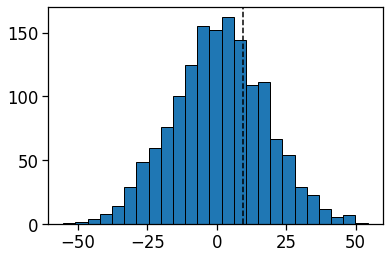

In [33]:
difference = results_P_noncarrier.params[1] - results_P_carrier.params[1]
permutationTest('P', difference)

0.4646666666666667

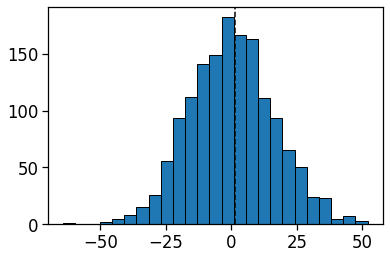

In [34]:
difference = results_Q_noncarrier.params[1] - results_Q_carrier.params[1]
permutationTest('Q', difference)

# VS Quartile Exploration
---

In [6]:
VS_data = data
VS_data.sort_values(by =['VS'], inplace = True)
VS_data['QuantileRank']= pd.qcut(data['VS'], q = 4, labels = False)

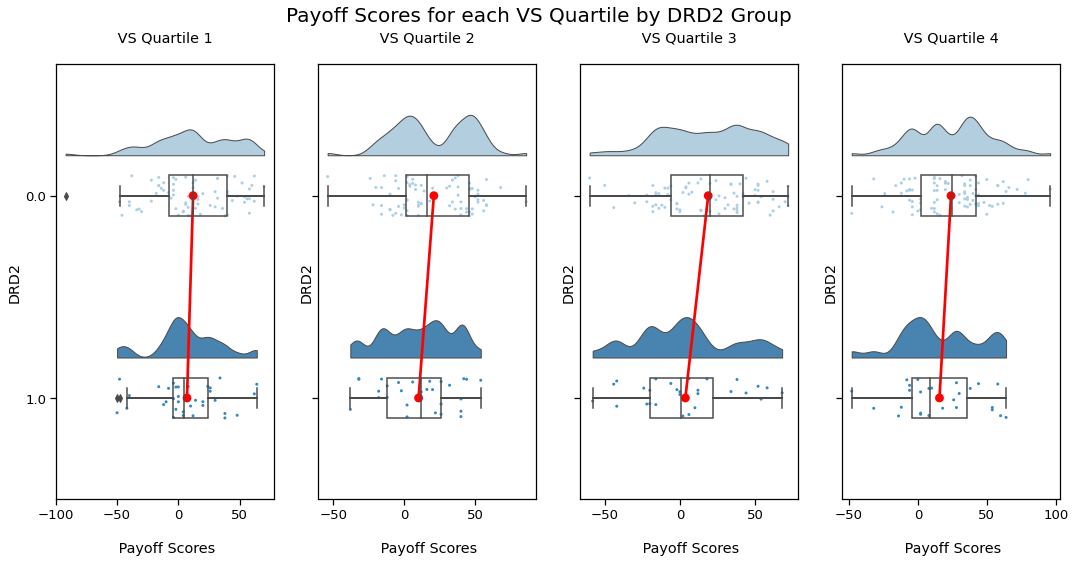

In [110]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.2)

# Configuring 1st row of grid of plots
fig, axs = plt.subplots(1, 4,  figsize=(18,8), sharey=True)

axs = axs.ravel()

fig.suptitle('Payoff Scores for each VS Quartile by DRD2 Group \n', fontsize=20, ha='center')


for i in range(4):
    curr_ax = axs[i]
    VS_curr_data = VS_data[VS_data["QuantileRank"] == i]
    VS = pt.RainCloud(y='P', x='DRD2', orient='h',data=VS_curr_data, width_viol=.4, width_box=.2, 
                   palette='Blues', pointplot=True, ax=curr_ax)
    VS.set(xlabel='\n Payoff Scores')
    VS.set_title(f'\n VS Quartile {i+1} \n')

### VS Tertiles Percentage of Carriers

# Linear Regression Models for VS Tertiles
---

## P ~ DRD2 + VS +  DRD2*VS + AGE + female_1

VS Quartile 1

In [118]:
VS_data_Q1 = VS_data[VS_data["QuantileRank"] == 0]
results_P_VS_Q1 = smf.ols(formula='P ~ DRD2 + VS + DRD2*VS + AGE + female_1', data=VS_data_Q1).fit()
HTML(results_P_VS_Q1.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,29.4209,16.613,1.771,0.080,-3.524,62.365
DRD2,-15.7422,9.211,-1.709,0.090,-34.008,2.524
VS,18.0557,36.950,0.489,0.626,-55.218,91.330
DRD2:VS,-65.5015,67.655,-0.968,0.335,-199.665,68.662
AGE,-0.0235,0.402,-0.058,0.954,-0.821,0.774
female_1,-24.4401,5.953,-4.106,0.000,-36.244,-12.636


In [121]:
results_P_VS_Q1.params["DRD2"]

Intercept    29.420890
DRD2        -15.742160
VS           18.055731
DRD2:VS     -65.501484
AGE          -0.023519
female_1    -24.440055
dtype: float64

VS Quartile 2

In [28]:
VS_data_Q2 = VS_data[VS_data["QuantileRank"] == 1]
results_P_VS_Q2 = smf.ols(formula='P ~ DRD2 + VS + DRD2*VS + AGE + female_1',data=VS_data_Q2).fit()
HTML(results_P_VS_Q2.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,25.6535,16.441,1.560,0.122,-6.953,58.260
DRD2,-0.5743,14.221,-0.040,0.968,-28.779,27.630
VS,-81.7551,115.662,-0.707,0.481,-311.143,147.632
DRD2:VS,-135.2193,220.398,-0.614,0.541,-572.327,301.888
AGE,0.1320,0.350,0.378,0.707,-0.561,0.826
female_1,-12.8277,5.059,-2.536,0.013,-22.861,-2.794


VS Quartile 3

In [29]:
VS_data_Q3 = VS_data[VS_data["QuantileRank"] == 2]
results_P_VS_Q3 = smf.ols(formula='P ~ DRD2 + VS + DRD2*VS + AGE + female_1',data=VS_data_Q3).fit()
HTML(results_P_VS_Q3.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,92.0947,23.978,3.841,0.000,44.541,139.649
DRD2,-48.1585,34.725,-1.387,0.168,-117.026,20.709
VS,-139.1167,114.685,-1.213,0.228,-366.567,88.333
DRD2:VS,224.7667,228.800,0.982,0.328,-229.004,678.538
AGE,-1.2485,0.383,-3.263,0.001,-2.007,-0.490
female_1,-0.8320,5.974,-0.139,0.890,-12.681,11.016


VS Quartile 4

In [30]:
VS_data_Q4 = VS_data[VS_data["QuantileRank"] == 3]
results_P_VS_Q4 = smf.ols(formula='P ~ DRD2 + VS + DRD2*VS + AGE + female_1',data=VS_data_Q4).fit()
HTML(results_P_VS_Q4.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.3420,19.014,0.334,0.739,-31.362,44.047
DRD2,-15.4428,20.214,-0.764,0.447,-55.527,24.642
VS,5.8227,29.609,0.197,0.844,-52.892,64.538
DRD2:VS,19.7695,60.555,0.326,0.745,-100.314,139.853
AGE,0.3890,0.409,0.952,0.343,-0.421,1.200
female_1,-2.0307,5.490,-0.370,0.712,-12.918,8.857


## Linear Regression Plots for each Quartile by Group

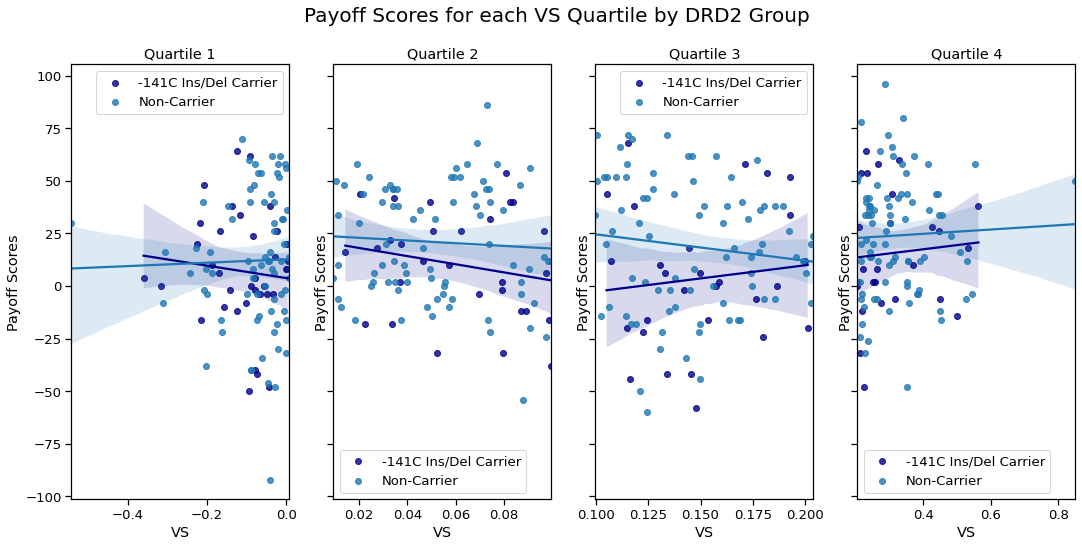

In [34]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.2)

# Configuring 1st row of grid of plots

fig, axs = plt.subplots(1, 4,  figsize=(18,8), sharey=True)

axs = axs.ravel()

fig.suptitle('Payoff Scores for each VS Quartile by DRD2 Group', fontsize=20, ha='center')


for i in range(4):
    curr_ax = axs[i]
    curr_data = VS_data[VS_data["QuantileRank"] == i]
    curr_carrier_data = curr_data[curr_data["DRD2"] == 1]
    curr_noncarrier_data = curr_data[curr_data["DRD2"] == 0]
    
    scatter_P_carrier_1 = sns.regplot(x='VS', y='P', data=curr_carrier_data, label='-141C Ins/Del Carrier', 
                                  color="darkblue", ax=curr_ax).legend()
    scatter_P_noncarrier_1 = sns.regplot(x='VS', y='P', data=curr_noncarrier_data, label='Non-Carrier',
                                        ax=curr_ax).legend()
    curr_ax.set(xlabel='VS')
    curr_ax.set(ylabel='Payoff Scores')
    curr_ax.set_title(f'Quartile {i+1}')


## Bootstrap for DRD2 Coefficients
#### Defining the Bootstrap function for a boostrapped Linear Regression

In [99]:
# Bootstrap function for Bootstrapped data Linear Regression
curr_boot = bootstrap(sample=curr_data[['P', 'VS', 'DRD2']], fn=linreg, size=10000)

def linreg(curr_array):
    
    curr_df = pd.DataFrame(curr_array, columns = ['P', 'VS', 'DRD2'])
    
    results = smf.ols(formula='P ~ DRD2 + VS + DRD2*VS', data=curr_df).fit()

    return results.params["DRD2"]

#### Defining the Bootstrap loop for each VS Quartile

In [57]:
data_coef = {}
data_boot = pd.DataFrame(columns=['Qs','curr_boot'])

for i in range(4):
    curr_data = VS_data[VS_data["QuantileRank"] == i].reset_index()
    
    # DRD2 beta coefficient from Linear Regression calculation
    results = smf.ols(formula='P ~ DRD2 + VS + DRD2*VS', data=curr_data).fit()
    coef = results.params["DRD2"]
    
    data_coef[f'Q{i+1}'] = coef
    
    
    # Bootstrap calculations on mean VS per group
    curr_boot = bootstrap(sample=curr_data[['P', 'VS', 'DRD2']], fn=linreg, size=10000)
    
    for x in range(len(curr_boot)):
        df = pd.DataFrame([[f'Q{i+1}', curr_boot[x]]], columns=['Qs','curr_boot'])
        data_boot = data_boot.append(df)

## Bootstrapped $\beta_{DRD2}$ Coefficient Bar Plot

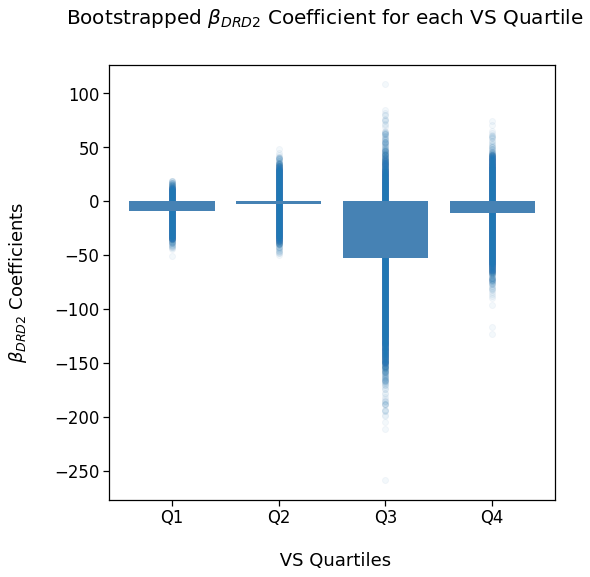

In [88]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.5)

fig = plt.figure(figsize=(8,8))

Qs = list(data_coef.keys())
coefs = list(data_coef.values()) 
plt.scatter('Qs', 'curr_boot', alpha=0.05, data=data_boot, edgecolor="steelblue")
plt.bar(x=Qs, height=coefs, color="steelblue")
fig.suptitle('Bootstrapped $\u03B2_{DRD2}$ Coefficient for each VS Quartile\n', fontsize=20, ha='center')
plt.xlabel(' \n VS Quartiles')
plt.ylabel('$\u03B2_{DRD2}$ Coefficients \n')
plt.show()